In [28]:
import numpy as np
import pandas as pd
import nltk
from nltk.stem import WordNetLemmatizer 
from sklearn import feature_extraction
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import text
from sklearn.metrics.pairwise import cosine_similarity
import joblib
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import os 
import re
import codecs
import copy
import matplotlib as mpl
from sklearn.manifold import MDS
from nltk.tag import pos_tag
from sklearn.metrics import homogeneity_score
from sklearn.metrics import silhouette_score
import seaborn as sn
from sklearn import metrics
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import DBSCAN
from sklearn.metrics.pairwise import cosine_distances
#import sklearn.external.joblib as extjoblib


In [2]:
def read_dataset(dataset_name):
    
    #messeges_csv, names_csv, tru_label_csv = pd.read_csv(dataset_name, usecols=['text','name','cluster'])
    messeges_csv = pd.read_csv(dataset_name, usecols=[0])
    names_csv = pd.read_csv(dataset_name, usecols=[1])
    tru_label_csv = pd.read_csv(dataset_name, usecols=[2])

    messeges = messeges_csv['text'].to_list()
    names = names_csv['name'].to_list()
    tru_label = tru_label_csv['cluster'].to_list()

    messeges = messeges[:150]
    names = names[:150]
    tru_label = tru_label[:150]
    
    print('Number of uploaded texts and names of authors:')
    print(str(len(messeges)) + ' messeges')
    #print(len(messeges))
    print(str(len(names)) + ' names')
    #print(names[:10])
    
    
    
    #visualizing the correct dataset labels
    cluster = tru_label_csv.groupby("cluster")

    plt.figure(figsize=(10,6))
    cluster.size().sort_values(ascending=False).plot.bar()
    plt.xticks(rotation=0)
    plt.title("Division of classes in a dataset")
    plt.ylabel("Number of texts")
    plt.xlabel("Class")
    plt.show()
    
    return messeges, names, tru_label

In [50]:
# here I define a tokenizer and lemmer which returns the set of stems in the text that it is passed

def tokenize_and_lemm(text):
    # load nltk's English stopwords as variable called 'stopwords'
    stopwords = nltk.corpus.stopwords.words('english')
    #print(stopwords[:50])
    lemmatizer = WordNetLemmatizer()
    
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    lemm = [lemmatizer.lemmatize(t) for t in filtered_tokens if t not in stopwords]  #delete stop words
    #print(lemm)
    return lemm


def tokenize_only(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    #print(filtered_tokens)        
    return filtered_tokens



def display_all_words(totalvocab_lemmed, visualize_all_words): 
    # Display the generated image:
    if(visualize_all_words == True):
        fig, ax = plt.subplots(figsize=(10, 6))   
        wordcloud = WordCloud(min_font_size=5, background_color="white").generate(str(totalvocab_lemmed))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis("off")
        plt.show()
    

In [42]:
def words_to_tfidf(messeges):
    my_stop_words = ["ha","le","u","wa","3rd","w","a","n't","vs.","'s","in","I","A","v","8c",
                                                     "0c","Is","As","ca","W","0C","eu","'re","'ve",]

    #define vectorizer parameters
    tfidf_vectorizer = TfidfVectorizer(min_df=0.01, tokenizer=tokenize_and_lemm, stop_words=my_stop_words)  

    tfidf_matrix = tfidf_vectorizer.fit_transform(messeges) #fit the vectorizer to synopses
    
    print('Tf-idf matrix shape: ', tfidf_matrix.shape)
    #print(tfidf_matrix)
    #print(tfidf_vectorizer.vocabulary_)
    
    terms = tfidf_vectorizer.get_feature_names()
    dist = 1 - cosine_similarity(tfidf_matrix)
    
    return tfidf_matrix,terms, dist

    

In [5]:
def kmeans_model(num_clusters, tfidf_matrix, save_to_pickle):

    km = KMeans(n_clusters=num_clusters, init="k-means++")
    %time km.fit(tfidf_matrix)

    labels_km = km.labels_
    clusters = km.labels_.tolist()
    #y_pred_km = km.predict(tfidf_matrix)

    #uncomment the below to save your model 
    #since I've already run my model I am loading from the pickle
    
    if(save_to_pickle == True):
        joblib.dump(km, 'doc_cluster.pkl')

    km = joblib.load('doc_cluster.pkl')

    for i in range(len(clusters)):
        if clusters[i] == 0:
            clusters[i] = 4
    #print(clusters)
    
    return clusters, labels_km, km


In [6]:
def top_terms_kmeans(km, visualize_top_terms):
    # Display the generated image:
    if (visualize_top_terms == True):
        
        print(" \n Top terms per cluster:")
        #print(type(terms))
        order_centroids = km.cluster_centers_.argsort()[:, ::-1]

        my_cloud=""
        for i in range(num_clusters):

            print("Cluster %d:" % i, end='')
            for ind in order_centroids[i, :11]:

                my_cloud = my_cloud +" "+ str(terms[ind])

            fig, ax = plt.subplots(figsize=(9, 4))   
            wordcloud = WordCloud(background_color="white").generate(my_cloud)
            plt.imshow(wordcloud, interpolation='bilinear')
            plt.axis("off")
            plt.show()
            my_cloud = " "
            

In [7]:
def change_dimensional(num_components):
    MDS()

    # two components as we're plotting points in a two-dimensional plane
    # "precomputed" because we provide a distance matrix
    # we will also specify `random_state` so the plot is reproducible.
    mds = MDS(n_components=num_components, dissimilarity="precomputed", random_state=1)

    pos = mds.fit_transform(dist)  # shape (n_components, n_samples)
    
    return pos


In [23]:
def plot_2d_kmeans(xs,ys,clusters,names, save_as_image_km):
    
     #set up colors per clusters using a dict
    cluster_colors = {4: '#1b9e77', 
                      2: '#d95f02', 
                      3: '#7570b3', 
                      1: '#e7298a'}

    #set up cluster names using a dict
    cluster_names = {1: 'Cluster 1', 
                     2: 'Cluster 2', 
                     3: 'Cluster 3', 
                     4: 'Cluster 4'}

    %matplotlib inline
    
    #create data frame that has the result of the MDS plus the cluster numbers and titles
    df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=names)) 
    
    #group by cluster
    groups = df.groupby('label')
    
    # set up plot
    fig, ax = plt.subplots(figsize=(17, 9)) # set size
    ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

    #iterate through groups to layer the plot
    #note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
    for name, group in groups:
        ax.plot(group.x, group.y, marker='o', linestyle='', ms=15, label=cluster_names[name], color=cluster_colors[name], mec='none')
        ax.set_aspect('auto')
        ax.tick_params(\
            axis = 'x',          # changes apply to the x-axis
            which ='both',      # both major and minor ticks are affected
            bottom ='off',      # ticks along the bottom edge are off
            top ='off',         # ticks along the top edge are off
            labelbottom ='off')
        ax.tick_params(\
            axis = 'y',         # changes apply to the y-axis
            which ='both',      # both major and minor ticks are affected
            left ='off',      # ticks along the bottom edge are off
            top ='off',         # ticks along the top edge are off
            labelleft ='off')

    ax.legend(numpoints = 1)  #show legend with only 1 point

    #add label in x,y position with the label as the film title
    for i in range(len(df)):
        ax.text(df.iloc[i]['x'], df.iloc[i]['y'], df.iloc[i]['title'], size=8)  

    plt.show() #show the plot

    #save the plot if need be
    if(save_as_image == True):
        plt.savefig('clusters_image_k-means.png', dpi=200)


In [9]:
# Dimension change by 3 dimensions and 3D vozualization for K-Means

def plot_3d_kmeans(zs2, ys2, xs2, km_cluster1,km_cluster2,km_cluster3, labels_km):
    #Plot the clusters obtained using k means
    fig = plt.figure(figsize=(17,9))
    ax = fig.add_subplot(111, projection='3d')

    #scatter = ax.scatter()
    scatter = ax.scatter(zs2, ys2, xs2,
                         c=labels_km, s=60, cmap="rainbow")


    ax.set_title('K-Means Clustering')
    ax.legend()
    plt.show()


In [40]:
def dbscan_model(tfidf_matrix, save_as_image_db):
    #Changing the dimension of the matrix for the DBSCAN algorithm

    svd = TruncatedSVD(n_components=3, random_state=1)
    X_svd = svd.fit_transform(tfidf_matrix)
    #print(f"Total variance explained: {np.sum(svd.explained_variance_ratio_):.2f}")

    print("Dimension changed from ", tfidf_matrix.shape," to ", X_svd.shape)

    # Compute DBSCAN

    db = DBSCAN(eps=0.1, min_samples=20)
    %time db.fit(X_svd)
    labels = db.labels_
    y_pred_db = db.fit_predict(X_svd)

    no_clusters = len(np.unique(labels))
    no_noise = np.sum(np.array(labels) == -1, axis=0)

    print('Estimated no. of clusters: %d' % no_clusters)
    print('Estimated no. of noise points: %d' % no_noise)
    print("\n", labels)


    # Generate scatter plot for training data
    fig, ax = plt.subplots(figsize=(14, 8))
    ax.margins(0.05)
    ax.plot(marker='o', linestyle='', ms=15, mec='none')

    plt.scatter(X_svd[:,0], X_svd[:,1],c=y_pred_db, cmap='Paired')
    plt.title("DBSCAN")
    
    if(save_as_image_db == True):
        plt.savefig('clusters_image_dbscan.png', dpi=200)
    
    # 3D vozualization for DBSCAN
    fig = plt.figure(figsize=(17,9))
    ax = fig.add_subplot(111, projection='3d')

    scatter = ax.scatter(X_svd[:,0], X_svd[:,1],X_svd[:,2],
                         c=y_pred_db,s=60, cmap="rainbow")

    ax.set_title('DBSCAN Clustering')
    ax.legend()
    plt.show()

    return y_pred_db,labels,no_clusters


In [11]:
def labels_to_original(labels, original_corpus):
    #assert len(labels) == len(original_corpus)
    max_label = max(labels)
    number_label = [i for i in range(0, max_label + 1, 1)]
    number_label.append(-1)
    result = [[] for i in range(len(number_label))]
    for i in range(len(labels)):
        index = number_label.index(labels[i])
        result[index].append(original_corpus[i])
    return result


def world_in_cluster(labels_original, no_clusters, visualize_words_in_cluster):
    
    if(visualize_words_in_cluster == True):
        my_cloud_db =" "
        for i in range(no_clusters):
            #print(labels_original[i])
            print("Cluster %d:" % i, end='')

            my_cloud_db = my_cloud_db +" "+ str(labels_original[i])

            fig, ax = plt.subplots(figsize=(10, 7))   
            wordcloud = WordCloud(max_font_size = 30,min_font_size = 5, background_color="white").generate(my_cloud_db)
            # Display the generated image:
            plt.imshow(wordcloud, interpolation='bilinear')
            plt.axis("off")
            plt.show()
            my_cloud_db = " "


In [12]:
def homogeneity_and_silhouette_score(tru_label, tfidf_matrix, clusters):
    homogeneity = homogeneity_score(tru_label, clusters).round(5)
    silhouette = silhouette_score(tfidf_matrix, clusters).round(5)
    
    return homogeneity, silhouette

In [13]:
def confusion_matrix(actual, predicted):

    data = {'y_Actual': actual,
            'y_Predicted': predicted
            }


    fig, ax = plt.subplots(figsize=(9, 5)) 
    df = pd.DataFrame(data, columns=['y_Actual','y_Predicted'])
    confusion_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['Actual'], colnames=['Predicted'], margins=True)
    sn.heatmap(confusion_matrix, annot=True)
    plt.show()


    # Printing the precision and recall, among other metrics
    print(metrics.classification_report(actual, predicted))

    #Printing the precision and recall to evaluate the whole algorithm
    print('Precision score (weighted avg): ', metrics.precision_score(actual, predicted, average='weighted').round(5))
    print('Precision score (macro avg): ', metrics.precision_score(actual, predicted, average='macro').round(5))

    print('Recall score (weighted avg): ', metrics.recall_score(actual, predicted, average='weighted').round(5))
    print('Recall score (macro avg): ', metrics.recall_score(actual, predicted, average='macro').round(5))

    print('F1 score (weighted avg): ', metrics.f1_score(actual, predicted, average='weighted').round(5))
    print('F1 score (macro avg): ', metrics.f1_score(actual, predicted, average='macro').round(5))

    print('Accuracy score: ', metrics.accuracy_score(actual, predicted).round(5),'\n')
    

Number of uploaded texts and names of authors:
150 messeges
150 names


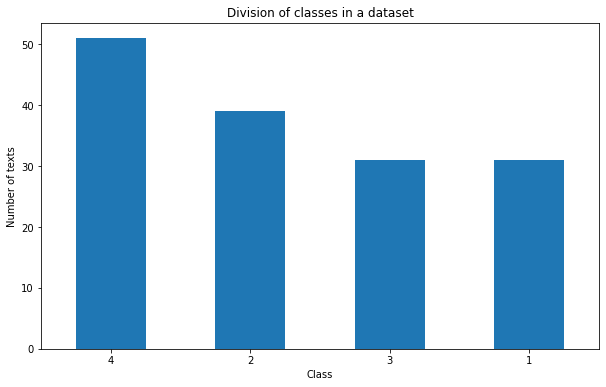

Words from the basic dictionary without tokenization, deletion of stop words and lemmatization: 
 ['they', 'seem', 'to', 'have', 'a', 'hold', 'on', 'it', 'in', 'korea', 'the', 'next', 'week', 'will', 'be', 'important', 'imo', 'to', 'see', 'if'] 

Tokenized and lemmatized words without stop words: 
 ['They', 'seem', 'hold', 'Korea', 'next', 'week', 'important', 'imo', 'see', 'number', 'drop', 'rate', 'could', 'resuming', 'life', 'next', 'month', 'go', 'line', 'rumour']


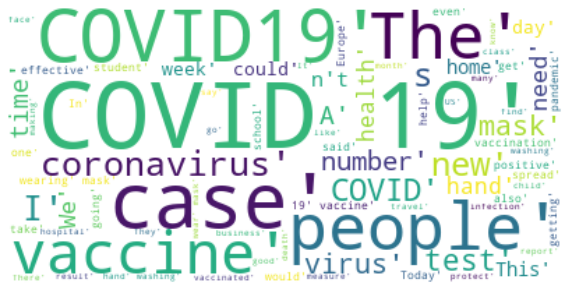

Tf-idf matrix shape:  (150, 414)
Wall time: 59 ms
 
 Top terms per cluster:
Cluster 0:

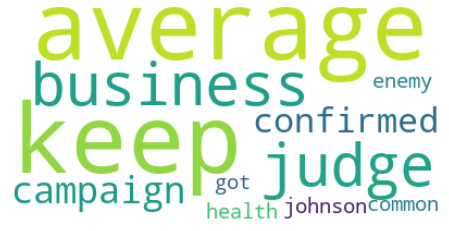

Cluster 1:

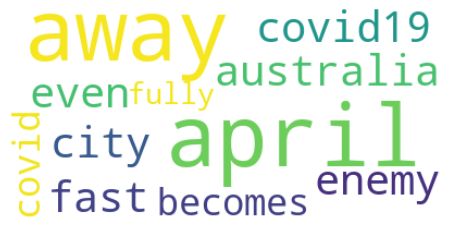

Cluster 2:

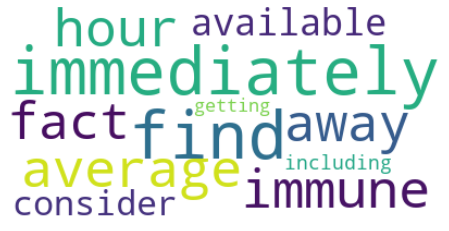

Cluster 3:

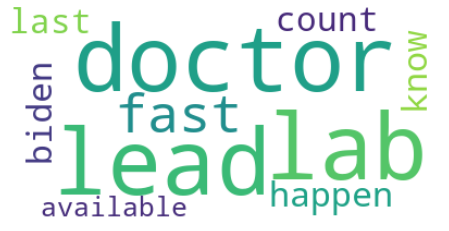

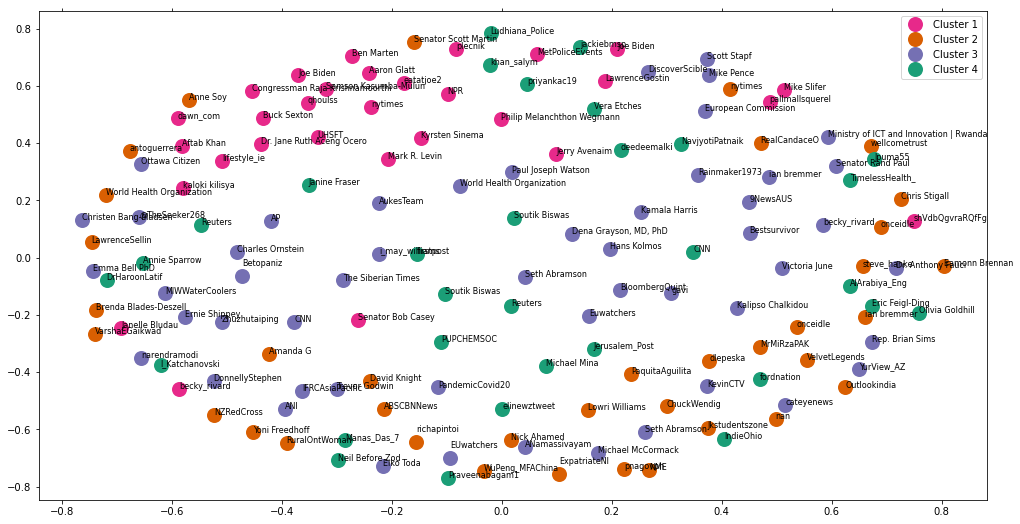

No handles with labels found to put in legend.


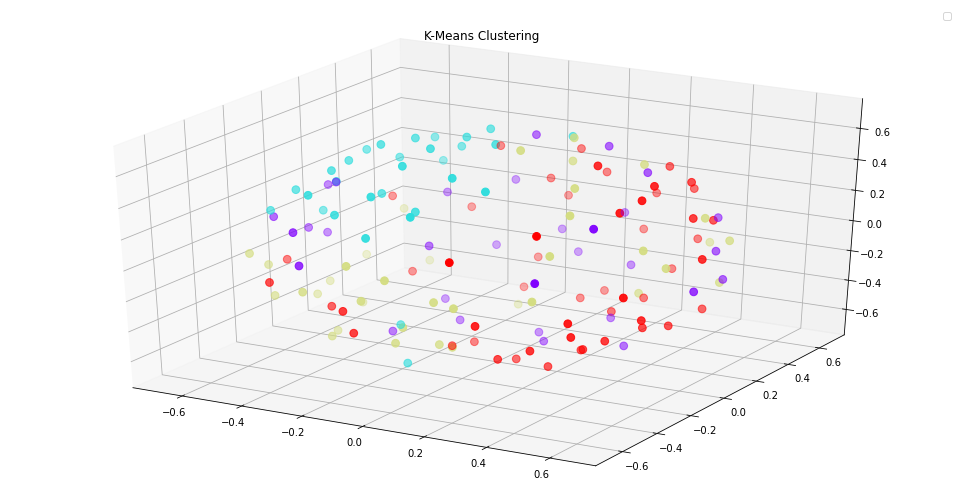

No handles with labels found to put in legend.


Dimension changed from  (150, 414)  to  (150, 3)
Wall time: 4.97 ms
Estimated no. of clusters: 2
Estimated no. of noise points: 57

 [ 0 -1 -1  0 -1  0 -1  0  0  0  0  0 -1 -1  0  0  0  0  0  0  0  0  0  0
  0  0 -1  0 -1  0 -1  0 -1  0  0  0  0  0 -1 -1  0  0 -1 -1 -1 -1 -1 -1
 -1  0 -1 -1 -1 -1 -1 -1  0 -1  0  0  0 -1 -1 -1  0  0  0  0  0  0  0  0
 -1 -1 -1  0  0  0  0  0  0 -1  0 -1 -1 -1 -1 -1  0  0 -1  0 -1 -1 -1 -1
 -1  0  0  0 -1  0  0  0  0  0  0 -1  0 -1  0  0  0  0  0  0 -1  0 -1  0
  0  0  0 -1  0 -1 -1  0  0  0  0  0 -1  0  0  0  0 -1  0 -1  0  0 -1  0
  0  0 -1  0  0  0]


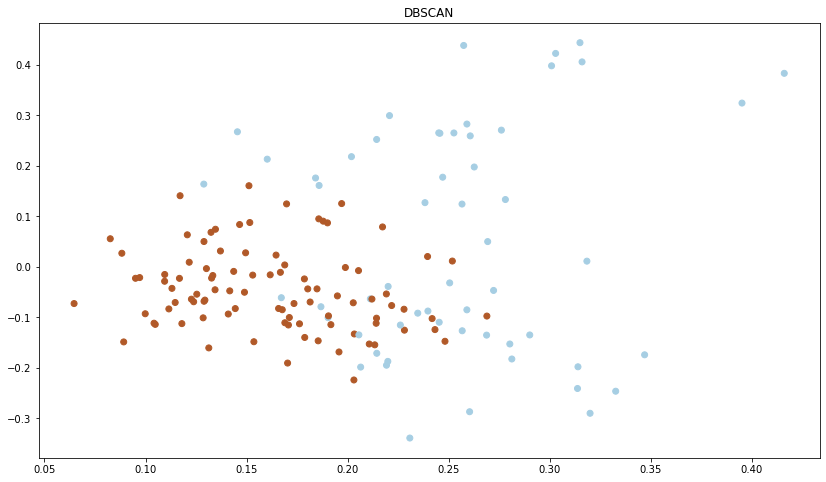

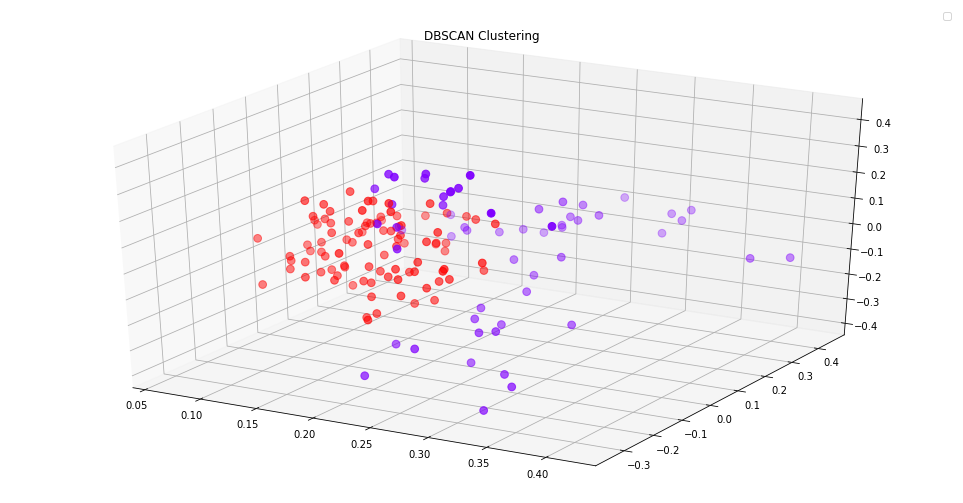

Cluster 0:

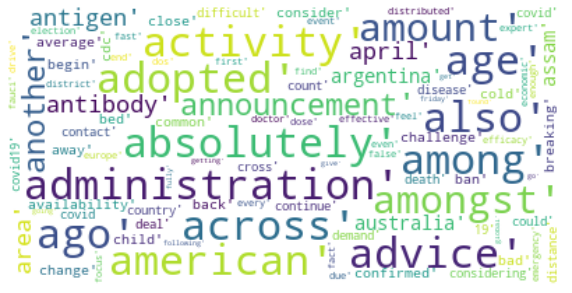

Cluster 1:

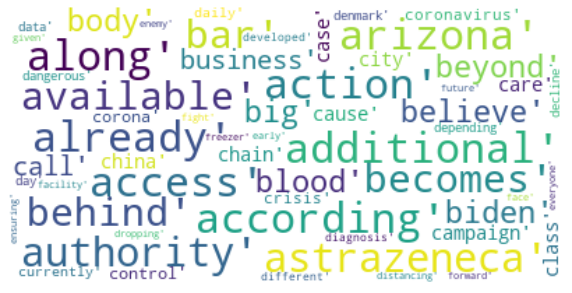

Homogeneity score for K-means:  0.23632
Silhouette score for K-means:  0.0107 

Homogeneity score for DBSCAN:  0.15229
Silhouette score for DBSCAN:  0.00389 

Confusion matrix for K-means: 


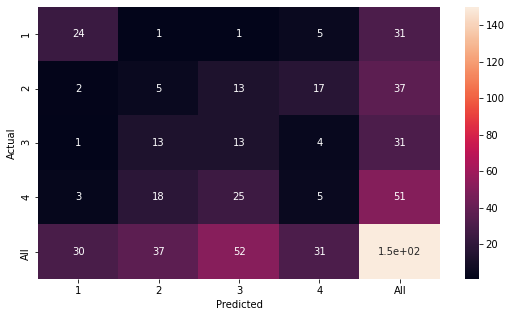

              precision    recall  f1-score   support

           1       0.80      0.77      0.79        31
           2       0.14      0.14      0.14        37
           3       0.25      0.42      0.31        31
           4       0.16      0.10      0.12        51

    accuracy                           0.31       150
   macro avg       0.34      0.36      0.34       150
weighted avg       0.31      0.31      0.30       150

Precision score (weighted avg):  0.30517
Precision score (macro avg):  0.33661
Recall score (weighted avg):  0.31333
Recall score (macro avg):  0.35668
F1 score (weighted avg):  0.30216
F1 score (macro avg):  0.33931
Accuracy score:  0.31333 

Confusion matrix for DBSCAN: 


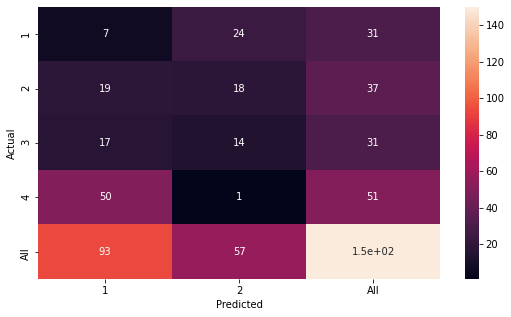

              precision    recall  f1-score   support

           1       0.08      0.23      0.11        31
           2       0.32      0.49      0.38        37
           3       0.00      0.00      0.00        31
           4       0.00      0.00      0.00        51

    accuracy                           0.17       150
   macro avg       0.10      0.18      0.12       150
weighted avg       0.09      0.17      0.12       150

Precision score (weighted avg):  0.09345
Precision score (macro avg):  0.09776
Recall score (weighted avg):  0.16667
Recall score (macro avg):  0.17807
F1 score (weighted avg):  0.1178
F1 score (macro avg):  0.12397
Accuracy score:  0.16667 



C:\Users\x17\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\x17\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [55]:
if __name__ == "__main__":
    
    dataset_name = 'dataset2.csv'  
    messeges, names, tru_label = read_dataset(dataset_name)
    
### dtatset    
    ranks = []
    for i in range(0,150):
        ranks.append(i)
        
### tokenize and lemm 

    #not super pythonic, no, not at all.
    #use extend so it's a big flat list of vocab
    totalvocab_lemmed = []
    totalvocab_tokenized = []

    for i in messeges:

        allwords_lemmed = tokenize_and_lemm(i)    #for each item in 'messeges', tokenize/stem    
        totalvocab_lemmed.extend(allwords_lemmed)    #extend the 'totalvocab_stemmed' list

        allwords_tokenized = tokenize_only(i)
        totalvocab_tokenized.extend(allwords_tokenized)
        
    print("Words from the basic dictionary without tokenization, deletion of stop words and lemmatization: \n",totalvocab_tokenized[:20],"\n") 
    print("Tokenized and lemmatized words without stop words: \n",totalvocab_lemmed[:20]) 
        
### display words
    visualize_all_words = True
    display_all_words(totalvocab_lemmed, visualize_all_words)
    
### create tf-idf  
    tfidf_matrix, terms, dist = words_to_tfidf(messeges)
    
### K-means
    num_clusters = 4
    save_to_pickle = False    # switch to True to save the model
                               # while it is False then the model will be loaded from the pickle
    clusters, labels_km, km = kmeans_model(num_clusters, tfidf_matrix, save_to_pickle)
    
###
    texts = {'messege': messeges,'rank': ranks,'cluster': clusters, 'name': names}
    frame = pd.DataFrame(texts, index = [clusters] , columns = ['rank','messege','cluster','name'])

    frame['cluster'].value_counts()
    grouped = frame['rank'].groupby(frame['cluster']) #groupby cluster for aggregation purposes
    grouped.mean() #average rank (1 to 100) per cluster
    
### words in cluster
    visualize_top_terms = True
    top_terms_kmeans(km, visualize_top_terms)

### change dimensional
    num_components = 2
    pos = change_dimensional(num_components)
    xs, ys = pos[:, 0], pos[:, 1]
    
### plot 2D k-means
    save_as_image_km = False
    plot_2d_kmeans(xs, ys, clusters, names, save_as_image_km)

#### Dimension change by 3 dimensions and 3D vozualization for K-Means
    num_components = 3
    pos = change_dimensional(num_components)
    xs2, ys2, zs2 = pos[:, 2], pos[:, 0], pos[:, 1]
    
### plot 3D k-means
    km_cluster1 = km.cluster_centers_[:, 2]
    km_cluster2 = km.cluster_centers_[:, 4]
    km_cluster3 = km.cluster_centers_[:, 1]
    plot_3d_kmeans(zs2, ys2, xs2, km_cluster1, km_cluster2, km_cluster3, labels_km)
    
### DBSCAN   
    save_as_image_db = False
    y_pred_db, labels, no_clusters = dbscan_model(tfidf_matrix, save_as_image_db)
    
### words in cluster
    labels_original = labels_to_original(labels, terms)
    visualize_words_in_cluster = True
    world_in_cluster(labels_original, no_clusters, visualize_words_in_cluster)
    
###
    y_pred_db_copy = copy.copy(y_pred_db)
    for i in range(len(y_pred_db_copy)):
        if y_pred_db_copy[i] == -1:
            y_pred_db_copy[i] = 2
        if y_pred_db_copy[i] == 0:
            y_pred_db_copy[i] = 1    

    #print(y_pred_db)
       
### homogenity and silhuette
    kmeans_homogeneity, kmeans_silhouette = homogeneity_and_silhouette_score(tru_label, tfidf_matrix, clusters)
    print('Homogeneity score for K-means: ', kmeans_homogeneity)
    print('Silhouette score for K-means: ', kmeans_silhouette,"\n")
    
    dbscan_homogeneity, dbscan_silhouette = homogeneity_and_silhouette_score(tru_label, tfidf_matrix, y_pred_db_copy)
    print('Homogeneity score for DBSCAN: ', dbscan_homogeneity)
    print('Silhouette score for DBSCAN: ', dbscan_silhouette ,"\n")
    
### Confusion matrix
    print('Confusion matrix for K-means: ')
    confusion_matrix(tru_label, clusters)
    
    print('Confusion matrix for DBSCAN: ')
    confusion_matrix(tru_label, y_pred_db_copy)